In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config, sys_params
from BondingCurveNexus.param_functions import open_liq, wnxm_movement_per_eth
from BondingCurveNexus.sys_class import NexusSystem
from scipy.stats import lognorm
from tqdm import tqdm
from random import shuffle

In [2]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)
eth_price_usd = float(eth_client.get_eth_last_price()['ethusd'])
eth_price_usd

1337.57

In [3]:
supply_url = 'https://api.coingecko.com/api/v3/coins/wrapped-nxm'
wnxm_supply_now = requests.get(supply_url).json()['market_data']['total_supply']
wnxm_supply_now

2924429.56595416

In [4]:
system_instance = NexusSystem(liquidity_eth=open_liq(0.5), wnxm_move_size=wnxm_movement_per_eth(500_000))

In [5]:
sys_params.wnxm_price_now / system_instance.book_value()

0.4903596736031186

# Dutch Auction Modelling

## Dutch Auction Mechanism - Above Book

Assume that we start at book value, as new tokenomics will start below book; therefore the first time "above book" kicks in is at BV

2 Versions:
1. Uniswap v2 Curve to push price up when sales happen & downward ratchet towatds book value
2. Two-sided market, Uni v2 curve but with a 2.5% penalty for sales.

Floor at book value - we don't want to allow people to buy for less than BV. Below BV we have a one-sided market with a ratchet

### Initial Liquidity

40% is commited to investments and 10% can be treated as a buffer for claims, so let's assume we have ~50% of the capital pool to play with - define this as free_capital_perc.

We probably don't want to use all of it (need buffer for writing new covers etc.), so we can define another percentage for actual liquidity allocation to the notional uni curve, call this liq_alloc_perc.

We then use a formula to derive the initial liquidity of the ETH pool, with liq_alloc_perc as an input that can be varied.

For the above book section, we will likely have a lower amount than starting, as some capital will be used to close to book, so assume we have 1/4 of the capital in the pool to start.

In [6]:
opening_liquidity_eth = open_liq(0.25)
opening_liquidity_eth

19223.625

### wNXM Liquidity in Open Market

Obtained from https://www.coingecko.com/en/coins/wrapped-nxm#markets, summed +2% and -2% depth across all exchanges & averaged the two. Rounded to nearest 10k (last 23/08/2022)

In [7]:
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
wnxm_move_size

5.964593398000001e-07

In [8]:
# How a wNXM buy works:
# establish current price
wnxm_open_price = sys_params.wnxm_price_now
# establish number of wNXM bought
n_wnxm = 50000
# translate amount to ETH
n_eth = n_wnxm * wnxm_open_price
# establish closing price
wnxm_close_price = wnxm_open_price + n_eth * wnxm_movement_per_eth(250_000)
print(wnxm_open_price, n_eth, wnxm_close_price, wnxm_close_price/wnxm_open_price - 1)

0.01111553 555.7765 0.01177852616853271 0.059645933979999954


### NXM buy/sell sizing - Lognormal

lognormal distribution of size of a typical entry and exit in ETH

parameterised to median value being ~1 ETH, upper quartile ~4 ETH

In [9]:
entry_shape = 2
entry_loc = 0
entry_scale = 1

exit_shape = 2
exit_loc = 0
exit_scale = 1

In [10]:
pd.DataFrame(lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale, size=10_000)).describe()

,0
count,10000.000000
mean,6.816088
std,30.325371
min,0.000500
25%,0.256861
50%,0.983455
75%,3.758011
max,1066.504101


### NXM buys/sells from platform per day

Poisson distribution of number of entries & exits per day

In [11]:
lambda_entries = 5
lambda_exits = 5

In [12]:
pd.DataFrame(np.random.poisson(lam=lambda_entries, size=10_000)).describe()

,0
count,10000.000000
mean,4.966200
std,2.250725
min,0.000000
25%,3.000000
50%,5.000000
75%,6.000000
max,15.000000


### wNXM drift & diffusion

Relative % change in wNXM price on open market due to random fluctuations based on a normal distribution

In [13]:
wnxm_shifts_per_day = 5
wnxm_drift = 0
wnxm_diffusion = (1+0.02)**(1/wnxm_shifts_per_day) - 1

In [14]:
wnxm_diffusion

0.003968378704429121

### Ratchet sizing

Increase system NXM price by 0.5% per day, initially by just decreasing NXM quantity in pool

In [15]:
ratchet_up_perc = 0.005
ratchet_down_perc = 0.005

## Uniswap v2 OOP Class - Double-sided above BV

In [33]:
# Create class with initial liquidity parameters
model_days = 366
# assume we burn about 1m NXM & wNXM in the below book phase and used 20k ETH
open_nxm_burned = 1_000_000
open_eth_sold = 20_000
# set buy/sell spread above BV
spread = 0.025

class UniPool_AboveBV_Two_Sided:
    # initial parameters
    def __init__(self, liquidity_eth, wnxm_price, wnxm_move_size):
        # start at day 0
        self.current_day = 0
        
        # set wNXM and NXM supply, Capital Pool
        self.nxm_supply = system_instance.nxm_supply - open_nxm_burned
        self.wnxm_supply = wnxm_supply_now - open_nxm_burned
        self.cap_pool = system_instance.cap_pool - open_eth_sold
        
        # set initial wNXM price
        self.wnxm_price = wnxm_price      
        # set initial ETH liquidity
        self.liquidity_eth = liquidity_eth
        # set change in wnxm price per 1 ETH of wnxm bought/sold
        self.wnxm_move_size = wnxm_move_size
        
        # set buy/sell spread above BV
        self.spread = spread
        
        # set initial NXM liquidity based on opening wNXM price
        # assume that prices have converged after initial period
        self.liquidity_nxm = self.liquidity_eth / self.wnxm_price
        
        # set intial invariant 
        self.invariant = self.liquidity_eth * self.liquidity_nxm
        
        # base entries and exits using a poisson distribution
        self.base_daily_platform_buys = np.random.poisson(
                                                lam=lambda_entries,
                                                size=model_days)
        self.base_daily_platform_sales = np.random.poisson(
                                                lam=lambda_exits,
                                                size=model_days)
        

        
        # set cumulative parameters to 0
        self.eth_sold = 0
        self.eth_acquired = 0
        self.nxm_burned = 0
        self.nxm_minted = 0
        self.wnxm_removed = 0
        self.wnxm_created = 0
        
        # set tracking lists for individual instance
        self.cap_pool_prediction = [self.cap_pool]
        self.nxm_price_prediction = [self.nxm_price(action='buy')]
        self.wnxm_price_prediction = [self.wnxm_price]
        self.nxm_supply_prediction = [self.nxm_supply]
        self.wnxm_supply_prediction = [self.wnxm_supply]
        self.book_value_prediction = [self.book_value()]
        self.liquidity_nxm_prediction = [self.liquidity_nxm]
        self.liquidity_eth_prediction = [self.liquidity_eth]
        self.eth_sold_prediction = [self.eth_sold]
        self.eth_acquired_prediction = [self.eth_acquired]
        self.nxm_burned_prediction = [self.nxm_burned]
        self.nxm_minted_prediction = [self.nxm_minted]
        self.wnxm_removed_prediction = [self.wnxm_removed]
        self.wnxm_created_prediction = [self.wnxm_created]
        
        
    # system nxm price expressed in ETH
    def book_value(self):
        if self.nxm_supply == 0:
            return 0
        return self.cap_pool/self.nxm_supply
    
    def nxm_price(self, action):
        # apply spread to sales above BV
        if action == 'sale' and self.liquidity_eth / self.liquidity_nxm > self.book_value():
            return max((1 - self.spread) * self.liquidity_eth / self.liquidity_nxm,
                       self.book_value())
        
        # otherwise return price without spread
        return self.liquidity_eth / self.liquidity_nxm
    
    def nxm_sale_size(self, denom='nxm'):
        if denom == 'nxm':
            return lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale) / self.nxm_price(action='buy')
        elif denom == 'eth':
            return lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale)
        
    # one sale of n_nxm NXM
    def platform_nxm_sale(self, n_nxm):
        # limit number to total NXM
        n_nxm = min(n_nxm, self.nxm_supply)
        
        # apply haircut if we're above book
        # has to be here before we start moving pool liquidity around
        haircut = 0
        if self.liquidity_eth / self.liquidity_nxm > self.book_value():
            haircut = self.spread
        
        # add sold NXM to pool
        self.liquidity_nxm += n_nxm
        self.nxm_supply -= n_nxm
        
        # establish new value of eth in pool
        new_eth = self.invariant / self.liquidity_nxm
        delta_eth = self.liquidity_eth - new_eth
        
        # calculate haircut
        eth_spread = delta_eth * haircut
        # add back to new eth in pool and remove from delta eth
        delta_eth -= eth_spread
        new_eth += eth_spread
        
        # add ETH removed and nxm burned to cumulative total, update capital pool
        self.eth_sold += delta_eth
        self.cap_pool -= delta_eth
        self.nxm_burned += n_nxm
        
        # update ETH liquidity & invariant (which will change due to spread)
        self.liquidity_eth = new_eth
        self.invariant = self.liquidity_eth * self.liquidity_nxm
        
    # one buy of n_nxm NXM
    def platform_nxm_buy(self, n_nxm):
        # remove bought NXM and add to supply
        self.liquidity_nxm -= n_nxm
        self.nxm_supply += n_nxm
        
        # establish new value of eth in pool
        new_eth = self.invariant / self.liquidity_nxm
        delta_eth = new_eth - self.liquidity_eth
        
        # add ETH acquired and nxm minted to cumulative total, update capital pool
        self.eth_acquired += delta_eth
        self.cap_pool += delta_eth
        self.nxm_minted += n_nxm
        
        # update ETH liquidity
        self.liquidity_eth = new_eth
    
    def wnxm_market_buy(self, n_wnxm, arb=True):
        # limit number of wnxm bought to total supply
        n_wnxm = min(n_wnxm, self.wnxm_supply)
        
        # crude calc for ETH amount (assuming whole buy happens on opening price)
        n_eth = n_wnxm * self.wnxm_price
        
        # increase price depending on defined liquidity parameters
        self.wnxm_price += n_eth * self.wnxm_move_size
        
        # if used for arb, remove from supply
        if arb:
            self.wnxm_supply -= n_wnxm
            self.wnxm_removed += n_wnxm
    
    def wnxm_market_sell(self, n_wnxm, arb=True):
        # limit number of wnxm sold to total supply
        n_wnxm = min(n_wnxm, self.wnxm_supply)
        
        # crude calc for ETH amount (assuming whole sell happens on opening price)
        n_eth = n_wnxm * self.wnxm_price
        
        # decrease price depending on defined liquidity parameters
        self.wnxm_price -= n_eth * self.wnxm_move_size
        
        # if used for arb, add to supply
        if arb:
            self.wnxm_supply += n_wnxm
            self.wnxm_created += n_wnxm
    
    def arb_sale_transaction(self):
        # establish size of nxm sell
        num = self.nxm_sale_size(denom='nxm')
        # buy from open market
        self.wnxm_market_buy(n_wnxm=num, arb=True)
        # sell to platform
        self.platform_nxm_sale(n_nxm=num)
        
    def arb_buy_transaction(self):
        # establish size of nxm buy
        num = self.nxm_sale_size(denom='nxm')
        # buy from platform
        self.platform_nxm_buy(n_nxm=num)
        # sell to open market
        self.wnxm_market_sell(n_wnxm=num, arb=True)
    
    def ratchet_up(self, num, kind='nxm'): 
        if kind == 'nxm':
            self.liquidity_nxm -= num
        elif kind == 'eth':
            self.liquidity_eth += num

        self.invariant = self.liquidity_eth * self.liquidity_nxm

    def ratchet_down(self, num, kind='nxm'): 
        if kind == 'nxm':
            self.liquidity_nxm += num
        elif kind == 'eth':
            self.liquidity_eth -= num

        self.invariant = self.liquidity_eth * self.liquidity_nxm
    
    def wnxm_shift(self):
        # set percentage changes in wnxm price using a normal distribution
        self.wnxm_price *= (1 + np.random.normal(loc=wnxm_drift, scale=wnxm_diffusion))

    def one_day_passes(self):
        # create list of events and shuffle it
        events_today = []
#         events_today.extend(['ratchet'])
#         events_today.extend(['wnxm_shift'] * wnxm_shifts_per_day)
#         events_today.extend(['platform_buy'] * self.base_daily_platform_buys[self.current_day])
        events_today.extend(['platform_sale'] * self.base_daily_platform_sales[self.current_day])
#         shuffle(events_today)

        # LOOP THROUGH EVENTS OF DAY
        for event in events_today:
            
#             #-----WNXM ARBITRAGE-----#
#             # happens in between all events
#             while self.nxm_price(action='sale') > self.wnxm_price:
#                 self.arb_sale_transaction()
#             while max(self.nxm_price(action='buy'), self.book_value()) < self.wnxm_price:
#                 self.arb_buy_transaction()

            #-----RATCHET-----#
            if event == 'ratchet':
                # up if below BV
                if self.book_value() > self.nxm_price(action='sale'):
                    self.ratchet_up(num=ratchet_up_perc*self.liquidity_nxm, kind='nxm')

            #-----WNXM SHIFT-----#
            if event == 'wnxm_shift':
                self.wnxm_shift()

            #-----PLATFORM BUY-----#
            # not arbitrage-driven
            if event == 'platform_buy':
                # doesn't happen if wnxm price is below platform price or book value
                if max(self.nxm_price(action='buy'), self.book_value()) > self.wnxm_price:
                    continue

                # otherwise execute the buy
                self.platform_nxm_buy(n_nxm=self.nxm_sale_size())

            #-----PLATFORM SALE-----#
            # not arbitrage-driven
            if event == 'platform_sale':
                # doesn't happen if price is at or below book value for testing
                if self.nxm_price(action='sale') < self.book_value():
                    continue

                # otherwise execute the sell
                self.platform_nxm_sale(n_nxm=self.nxm_sale_size())
        
        # append values to tracking metrics
        self.cap_pool_prediction.append(self.cap_pool)
        self.nxm_price_prediction.append(self.nxm_price(action='buy'))
        self.wnxm_price_prediction.append(self.wnxm_price)
        self.nxm_supply_prediction.append(self.nxm_supply)
        self.wnxm_supply_prediction.append(self.wnxm_supply)
        self.book_value_prediction.append(self.book_value())
        self.liquidity_nxm_prediction.append(self.liquidity_nxm)
        self.liquidity_eth_prediction.append(self.liquidity_eth)
        self.eth_sold_prediction.append(self.eth_sold)
        self.eth_acquired_prediction.append(self.eth_acquired)
        self.nxm_burned_prediction.append(self.nxm_burned)
        self.nxm_minted_prediction.append(self.nxm_minted)
        self.wnxm_removed_prediction.append(self.wnxm_removed)
        self.wnxm_created_prediction.append(self.wnxm_created)
        
        # increment day
        self.current_day += 1

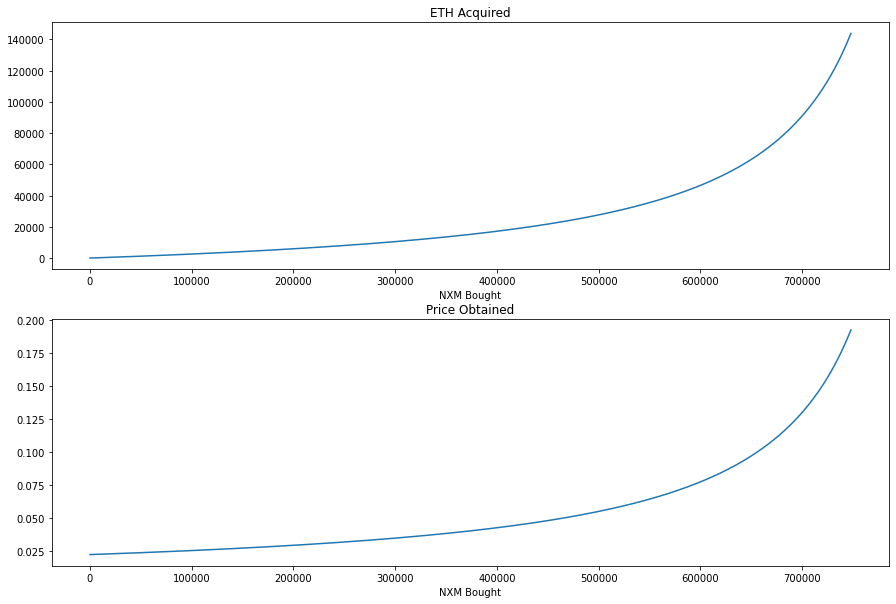

In [34]:
# buy size vs ETH and cost 
buy_sizes = np.linspace(100,
                         UniPool_AboveBV_Two_Sided(liquidity_eth=open_liq(0.25),
                                                   wnxm_price=system_instance.book_value(),
                                                   wnxm_move_size=wnxm_movement_per_eth(500_000))\
                        .liquidity_nxm-100_000,
                         1000)
eth_acquired = []
nxm_prices_obtained = []

for n_nxm in buy_sizes:
    sim = UniPool_AboveBV_Two_Sided(open_liq(0.25),
                                    wnxm_price=system_instance.book_value(),
                                    wnxm_move_size=wnxm_movement_per_eth(500_000))
    sim.platform_nxm_buy(n_nxm)
    eth_acquired.append(sim.eth_acquired)
    nxm_prices_obtained.append(sim.eth_acquired / n_nxm)
    
fig, axs = plt.subplots(2, 1, figsize=(15,10))
axs[0].plot(buy_sizes, eth_acquired)
axs[0].set_title('ETH Acquired')
axs[0].set_xlabel('NXM Bought')
axs[1].plot(buy_sizes, nxm_prices_obtained)
axs[1].set_title('Price Obtained')
axs[1].set_xlabel('NXM Bought');

## Tests

### Selling Above Book Value - Does BV get driven down too much?

Two things to test:
1. Price above BV
2. Amount of ETH liquidity

Modifications made to class instance:
- one_day_passes() only includes platform sells and nothing else
- replaced conditions on wnxm price for platform sells with a book value floor to test above BV only
- removed wNXM arbitrage

#### Varying price above BV

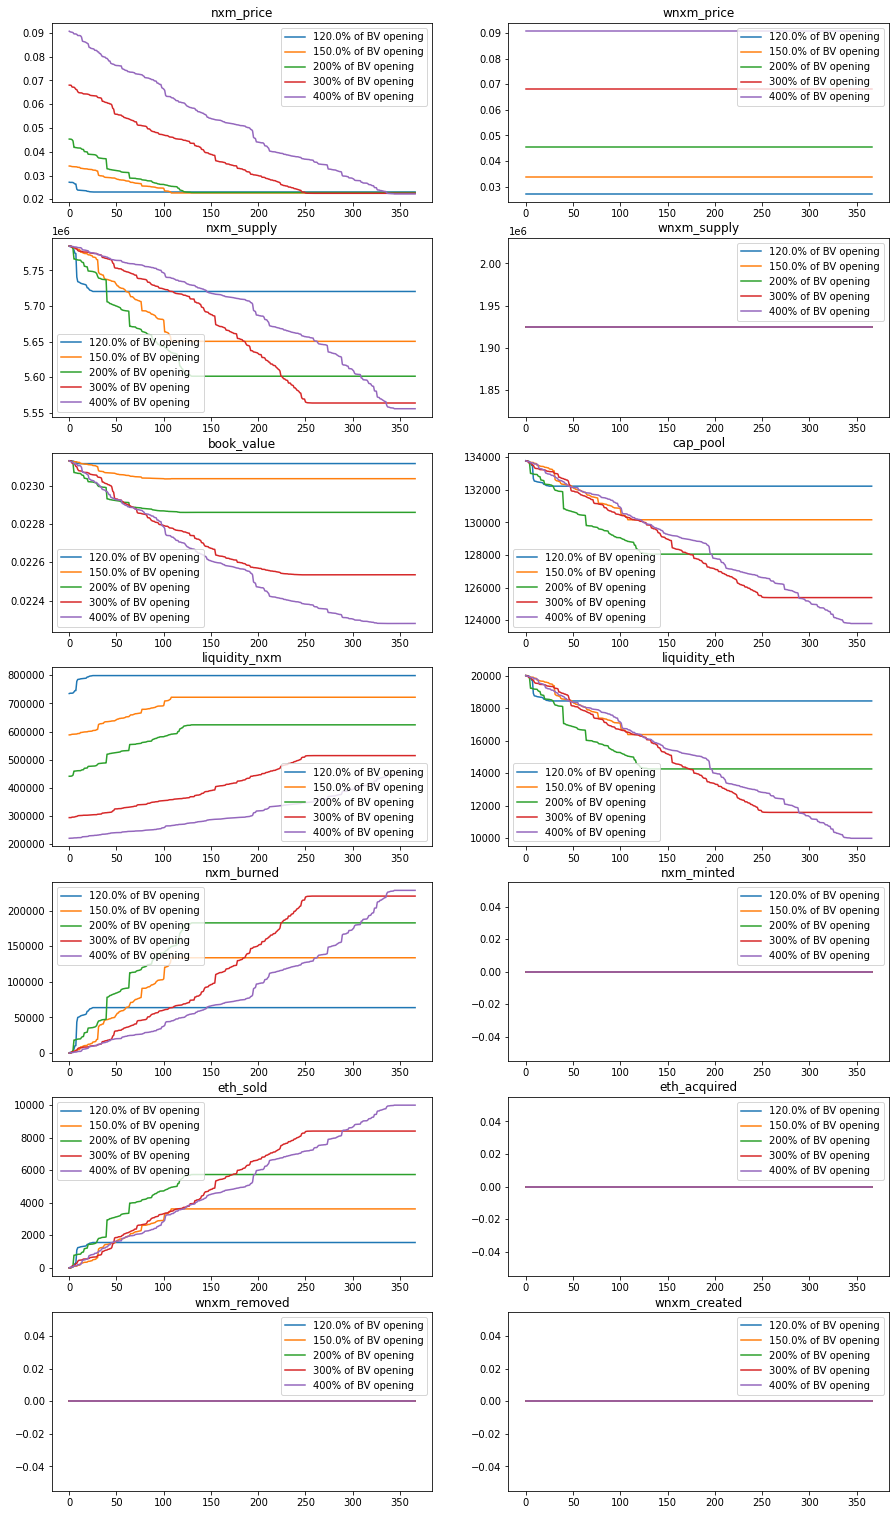

In [41]:
liquidity_eth = 20_000
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)

# opening price range expressed as percentages of Book Value
opening_price_range = [1.2, 1.5, 2, 3, 4]

sims = [UniPool_AboveBV_Two_Sided(liquidity_eth=liquidity_eth,
                                  wnxm_price=perc*system_instance.book_value(),
                                  wnxm_move_size=wnxm_move_size
                                  )
        for perc in opening_price_range]

for sim in sims:
    for i in range(model_days):
        sim.one_day_passes()

#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (7,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].nxm_minted_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[4, 1].set_title('nxm_minted')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 1].plot(range(model_days+1), sims[i].eth_acquired_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[5, 1].set_title('eth_acquired')
axs[5, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 0].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[6, 0].set_title('wnxm_removed')
axs[6, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 1].plot(range(model_days+1), sims[i].wnxm_created_prediction, label=f'{opening_price_range[i]*100}% of BV opening')
axs[6, 1].set_title('wnxm_created')
axs[6, 1].legend()

#plt.suptitle('Ratchet speed values')
plt.show()

#### Varying ETH liquidity

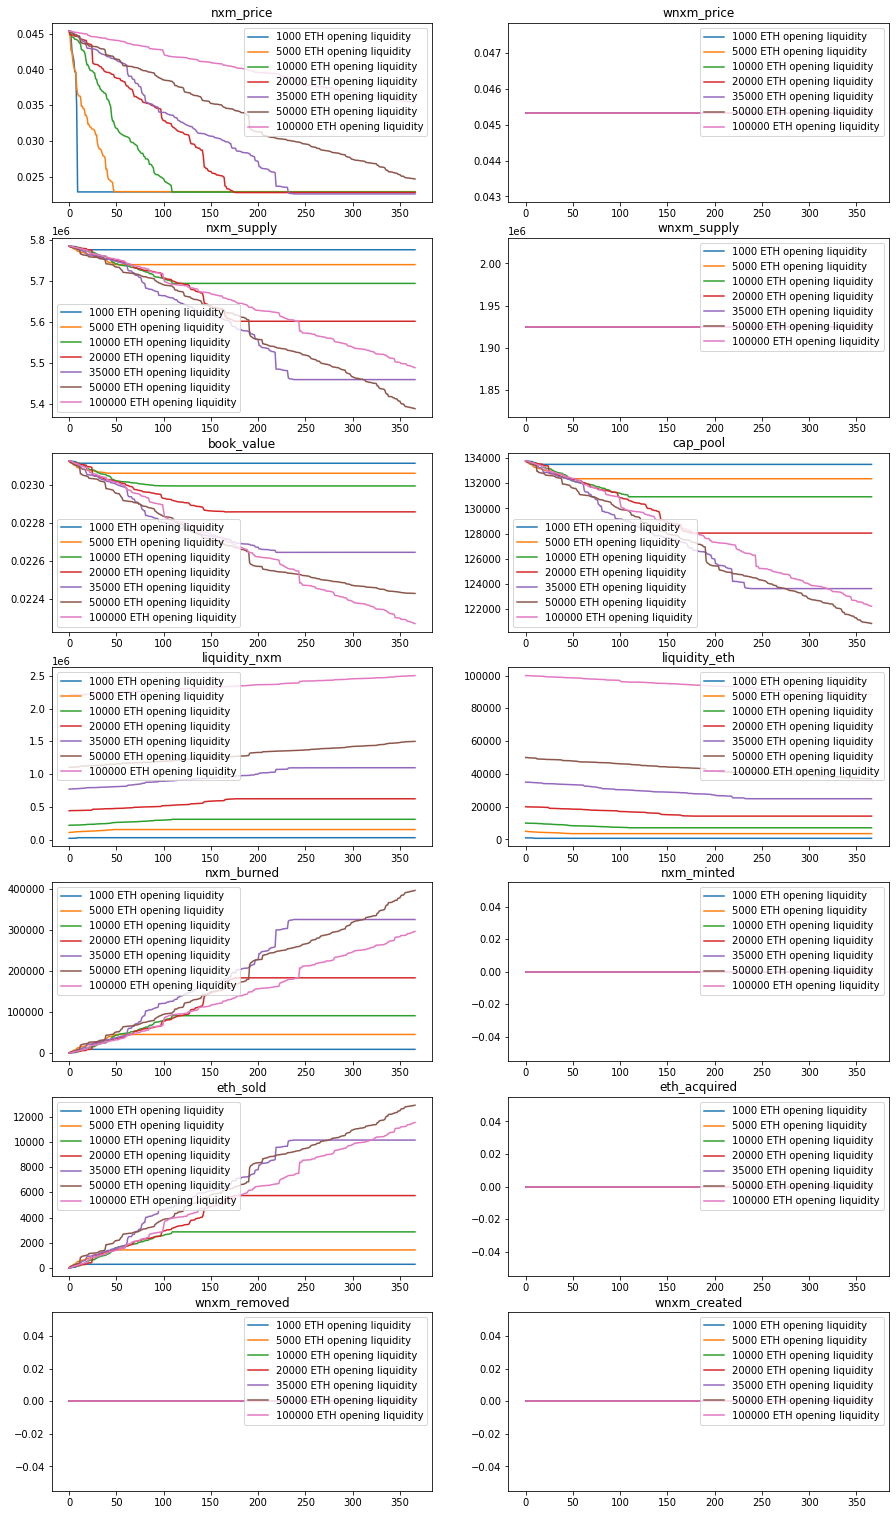

In [43]:
opening_perc_book_value = 2
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)

# opening price range expressed as percentages of Book Value
liquidity_range = [1_000, 5_000, 10_000, 20_000, 35_000, 50_000, 100_000]

sims = [UniPool_AboveBV_Two_Sided(liquidity_eth=liq,
                                  wnxm_price=opening_perc_book_value*system_instance.book_value(),
                                  wnxm_move_size=wnxm_move_size
                                  )
        for liq in liquidity_range]

for sim in sims:
    for i in range(model_days):
        sim.one_day_passes()

#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (7,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].nxm_minted_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[4, 1].set_title('nxm_minted')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 1].plot(range(model_days+1), sims[i].eth_acquired_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[5, 1].set_title('eth_acquired')
axs[5, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 0].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[6, 0].set_title('wnxm_removed')
axs[6, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 1].plot(range(model_days+1), sims[i].wnxm_created_prediction, label=f'{liquidity_range[i]} ETH opening liquidity')
axs[6, 1].set_title('wnxm_created')
axs[6, 1].legend()

plt.show()

### Set up Single Simulation

100%|███████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 1189.58it/s]


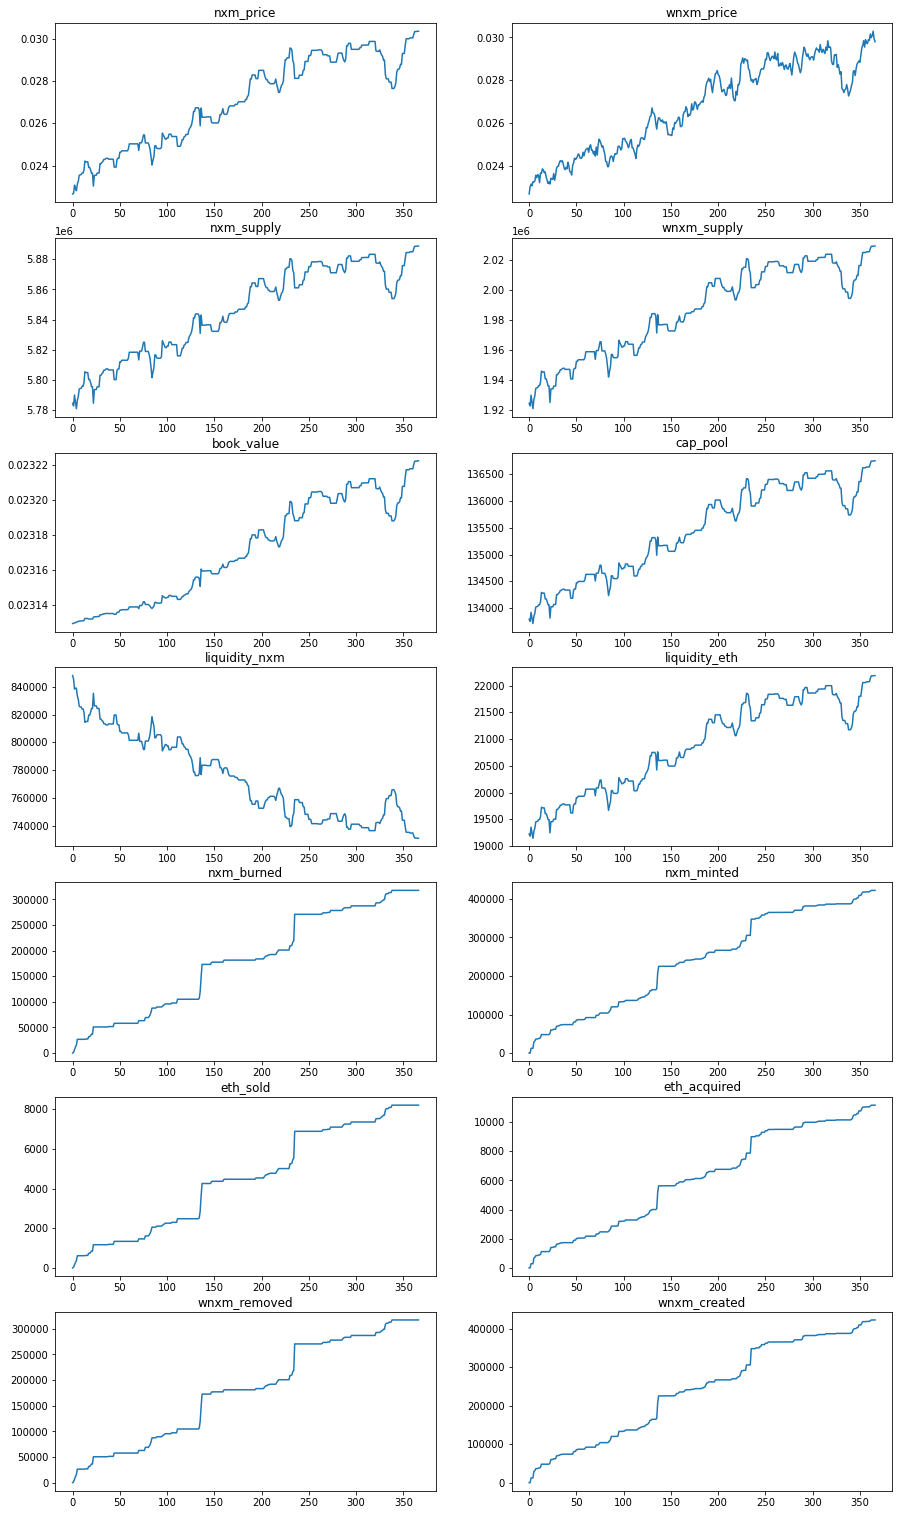

In [78]:
ratchet_perc = 0.005
liquidity_eth = open_liq(0.25)
wnxm_move_size = wnxm_movement_per_eth(500_000)

sim = UniPool_AboveBV_Two_Sided(liquidity_eth=liquidity_eth, wnxm_move_size=wnxm_move_size)

for i in tqdm(range(model_days)):
    sim.one_day_passes()
    
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (7,2) nd-array

# Subplot
axs[0, 0].plot(range(model_days+1), sim.nxm_price_prediction)
axs[0, 0].set_title('nxm_price')
# Subplot
axs[0, 1].plot(range(model_days+1), sim.wnxm_price_prediction)
axs[0, 1].set_title('wnxm_price')
# Subplot
axs[1, 0].plot(range(model_days+1), sim.nxm_supply_prediction)
axs[1, 0].set_title('nxm_supply')
# Subplot
axs[1, 1].plot(range(model_days+1), sim.wnxm_supply_prediction)
axs[1, 1].set_title('wnxm_supply')
# Subplot
axs[2, 0].plot(range(model_days+1), sim.book_value_prediction)
axs[2, 0].set_title('book_value')
# Subplot
axs[2, 1].plot(range(model_days+1), sim.cap_pool_prediction)
axs[2, 1].set_title('cap_pool')
# Subplot
axs[3, 0].plot(range(model_days+1), sim.liquidity_nxm_prediction)
axs[3, 0].set_title('liquidity_nxm')
# Subplot
axs[3, 1].plot(range(model_days+1), sim.liquidity_eth_prediction)
axs[3, 1].set_title('liquidity_eth')
# Subplot
axs[4, 0].plot(range(model_days+1), sim.nxm_burned_prediction)
axs[4, 0].set_title('nxm_burned')
# Subplot
axs[4, 1].plot(range(model_days+1), sim.nxm_minted_prediction)
axs[4, 1].set_title('nxm_minted')
# Subplot
axs[5, 0].plot(range(model_days+1), sim.eth_sold_prediction)
axs[5, 0].set_title('eth_sold')
# Subplot
axs[5, 1].plot(range(model_days+1), sim.eth_acquired_prediction)
axs[5, 1].set_title('eth_acquired')
# Subplot
axs[6, 0].plot(range(model_days+1), sim.wnxm_removed_prediction)
axs[6, 0].set_title('wnxm_removed')
# Subplot
axs[6, 1].plot(range(model_days+1), sim.wnxm_created_prediction)
axs[6, 1].set_title('wnxm_created')

plt.show()

In [72]:
print(sim.wnxm_price_prediction[300], sim.nxm_price_prediction[300], sim.book_value_prediction[300])

0.02616093857455645 0.02719403510785585 0.023213346023794122


In [73]:
sim.nxm_price_prediction[300] * (1-sim.spread)

0.026514184230159454

### NXM Supply rate change

We provide a range by which the ratcheting mechanism moves the wNXM price.

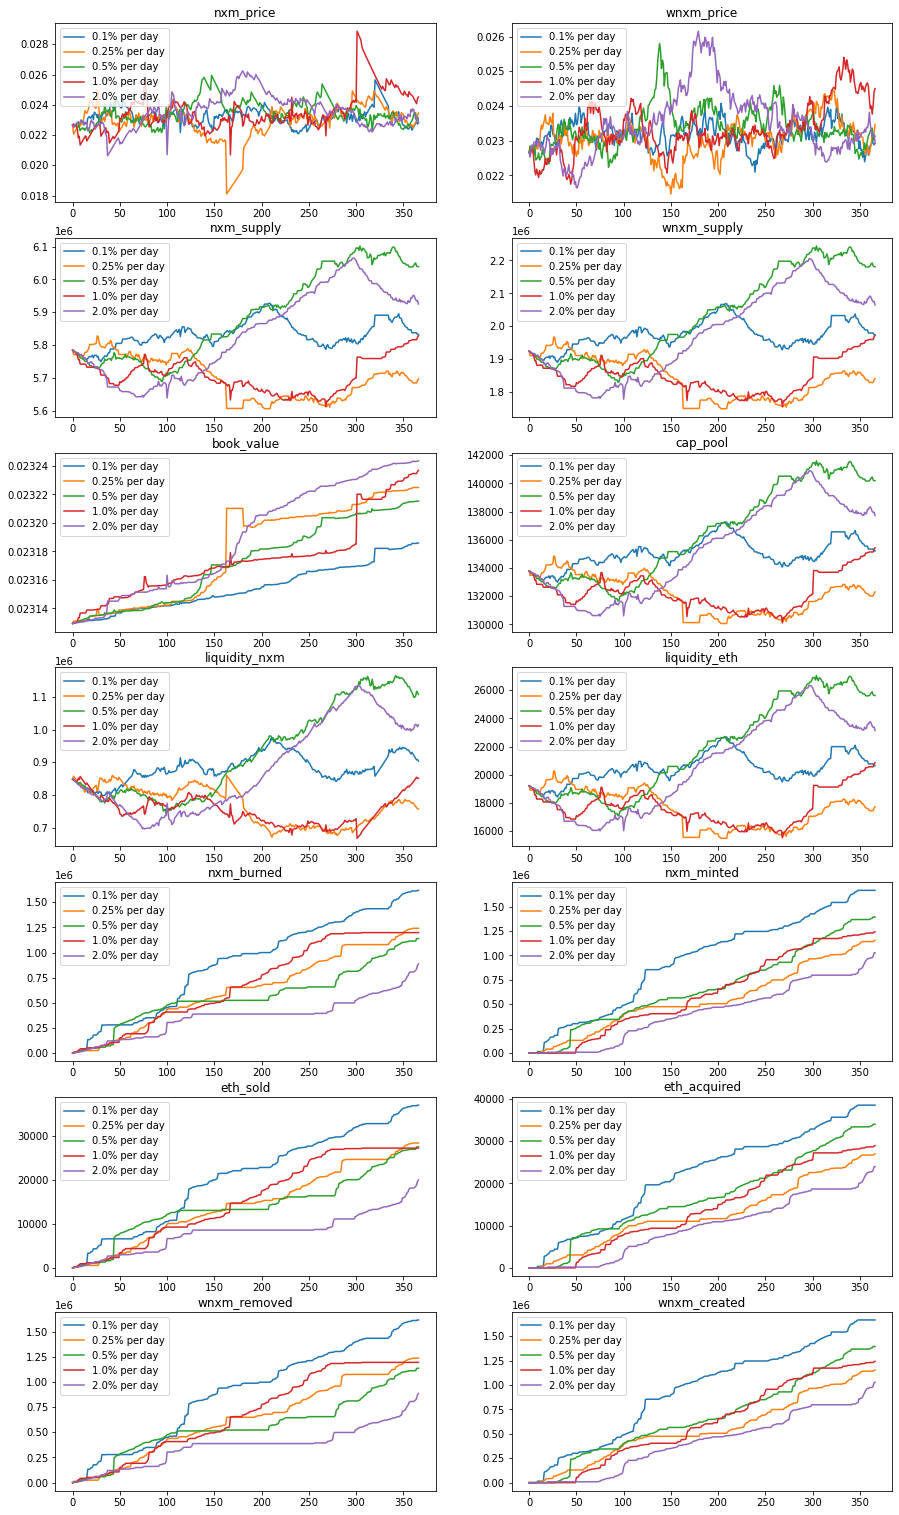

In [53]:
liquidity_eth = open_liq(0.25)
wnxm_move_size = wnxm_movement_per_eth(500_000)

ratchet_perc_options = [0.001, 0.0025, 0.005, 0.01, 0.02]

sims = [UniPool_AboveBV_One_Sided(liquidity_eth=liquidity_eth, wnxm_move_size=wnxm_move_size)
        for x in range(len(ratchet_perc_options))]

for n, sim in enumerate(sims):
    ratchet_perc = ratchet_perc_options[n]
    for i in range(model_days):
        sim.one_day_passes()

# for i in range(len(sims)):
#     plt.plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
# plt.title('nxm_price')
# plt.legend();
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (7,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].nxm_minted_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[4, 1].set_title('nxm_minted')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 1].plot(range(model_days+1), sims[i].eth_acquired_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[5, 1].set_title('eth_acquired')
axs[5, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 0].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[6, 0].set_title('wnxm_removed')
axs[6, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 1].plot(range(model_days+1), sims[i].wnxm_created_prediction, label=f'{ratchet_perc_options[i]*100}% per day')
axs[6, 1].set_title('wnxm_created')
axs[6, 1].legend()

#plt.suptitle('Ratchet speed values')
plt.show()

Doesn't seem to make much difference - largely dependent on wNXM volatility

### wNXM liquidity in markets

We test a range of available wNXM liquidity in markets. At current prices, according to coingecko, a 2% shift occurs approximately at $250k sold/bought. Likely that more market sellers will be available at higher prices, so most alternative liquidity parameter tests are explored upwards.

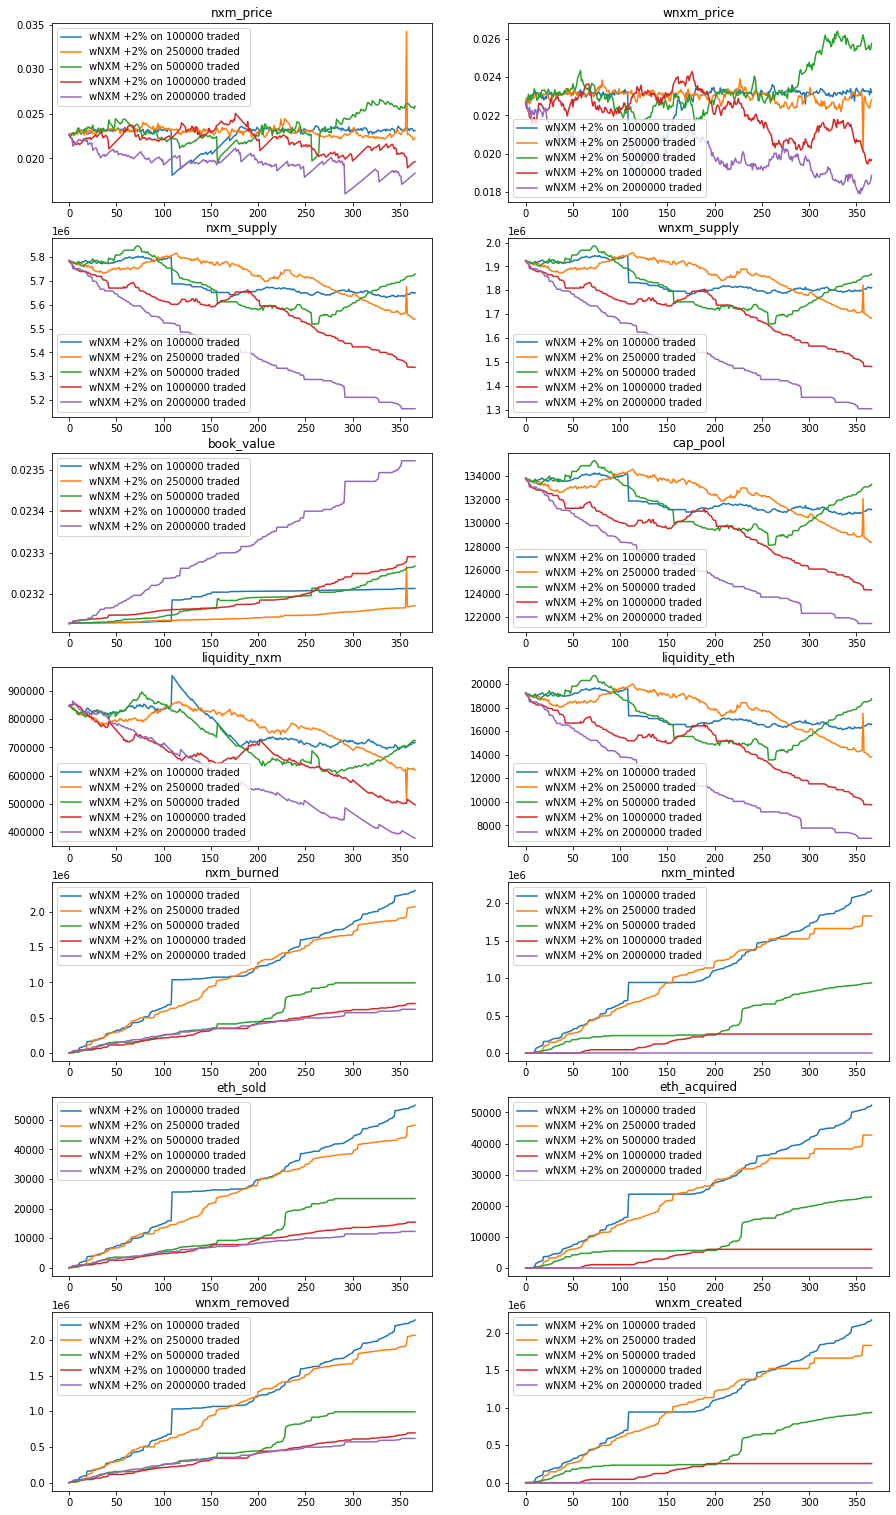

In [56]:
ratchet_perc = 0.005
opening_liquidity_eth = open_liq(0.5)

wnxm_liq_range_usd = [100_000, 250_000, 500_000, 1_000_000, 2_000_000]

sims = [UniPool_AboveBV_One_Sided(liquidity_eth=liquidity_eth, wnxm_move_size=wnxm_movement_per_eth(liq))
        for liq in wnxm_liq_range_usd]

for sim in sims:
    for i in range(model_days):
        sim.one_day_passes()

# for i in range(len(sims)):
#     plt.plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
# plt.title('nxm_price')
# plt.legend();        

#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (6,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].nxm_minted_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[4, 1].set_title('nxm_minted')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 1].plot(range(model_days+1), sims[i].eth_acquired_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[5, 1].set_title('eth_acquired')
axs[5, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 0].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[6, 0].set_title('wnxm_removed')
axs[6, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 1].plot(range(model_days+1), sims[i].wnxm_created_prediction, label=f'wNXM +2% on {wnxm_liq_range_usd[i]} traded')
axs[6, 1].set_title('wnxm_created')
axs[6, 1].legend()

plt.show()

Again, outcome depends on wNXM price fluctuation.

**Use for other range tests:** 500k USD shifts the wNXM price by _current wNXM price in ETH * 0.02_

### Change in initial ETH supply

Test whether there is much impact in terms of changing the initial supply of ETH that is provided to the liquidity pool.

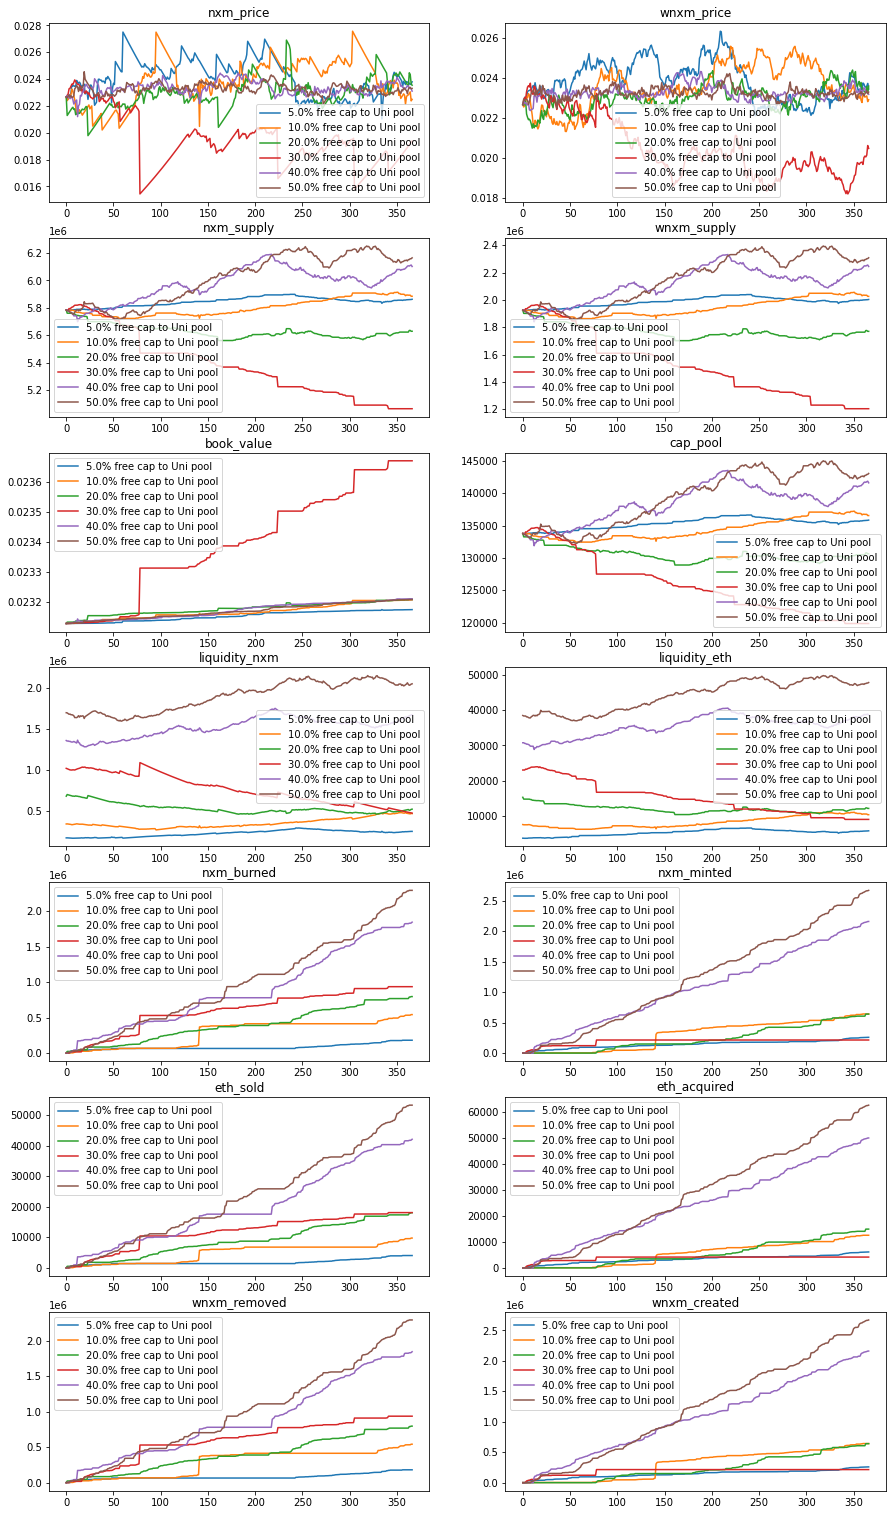

In [57]:
ratchet_perc = 0.005
wnxm_move_size = wnxm_movement_per_eth(500_000)

liq_perc_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

sims = [UniPool_AboveBV_One_Sided(liquidity_eth=open_liq(perc), wnxm_move_size=wnxm_move_size)
        for perc in liq_perc_range]

for sim in sims:
    for i in range(model_days):
        sim.one_day_passes()

# for i in range(len(sims)):
#     plt.plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
# plt.title('nxm_price')
# plt.legend(); 
        
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (6,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(model_days+1), sims[i].nxm_price_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(model_days+1), sims[i].wnxm_price_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(model_days+1), sims[i].nxm_supply_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(model_days+1), sims[i].wnxm_supply_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(model_days+1), sims[i].book_value_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(model_days+1), sims[i].cap_pool_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(model_days+1), sims[i].liquidity_nxm_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(model_days+1), sims[i].liquidity_eth_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 0].plot(range(model_days+1), sims[i].nxm_burned_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[4, 0].set_title('nxm_burned')
axs[4, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[4, 1].plot(range(model_days+1), sims[i].nxm_minted_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[4, 1].set_title('nxm_minted')
axs[4, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 0].plot(range(model_days+1), sims[i].eth_sold_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[5, 0].set_title('eth_sold')
axs[5, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[5, 1].plot(range(model_days+1), sims[i].eth_acquired_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[5, 1].set_title('eth_acquired')
axs[5, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 0].plot(range(model_days+1), sims[i].wnxm_removed_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[6, 0].set_title('wnxm_removed')
axs[6, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[6, 1].plot(range(model_days+1), sims[i].wnxm_created_prediction, label=f'{liq_perc_range[i]*100}% free cap to Uni pool')
axs[6, 1].set_title('wnxm_created')
axs[6, 1].legend()

plt.show()